In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
import time
from functools import partial

import jax.numpy as jnp
from jax import jit as jjit
from jax import random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.chains import run_sampling_nuts, run_warmup_nuts
from bpd.draw import draw_gaussian
from bpd.initialization import init_with_prior
from bpd.pipelines.image_samples import (
    get_target_images,
    get_true_params_from_galaxy_params,
    loglikelihood,
    logprior,
    logtarget,
)
from bpd.pipelines.image_samples import sample_target_galaxy_params_simple

import matplotlib.pyplot as plt

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-11-20 10:05:50.674693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Testing script

In [20]:
def sample_prior(
    rng_key: PRNGKeyArray,
    *,
    flux_bds: tuple = (2.5, 4.0),
    hlr_bds: tuple = (0.8, 3.0),
    shape_noise: float = 0.3,
    g1: float = 0.02,
    g2: float = 0.0,
) -> dict[str, float]:
    k1, k2, k3 = random.split(rng_key, 3)

    lf = random.uniform(k1, minval=flux_bds[0], maxval=flux_bds[1])
    hlr = random.uniform(k2, minval=hlr_bds[0], maxval=hlr_bds[1])

    other_params = sample_target_galaxy_params_simple(
        k3, shape_noise=shape_noise, g1=g1, g2=g2
    )

    return {"lf": lf, "hlr": hlr, **other_params}


def _sample_prior_init(rng_key: PRNGKeyArray):
    prior_samples = sample_prior(rng_key)
    truth_samples = get_true_params_from_galaxy_params(prior_samples)
    return truth_samples


INIT_FNC = partial(init_with_prior, prior=_sample_prior_init)

In [21]:
rng_key = random.key(45)
pkey, nkey, gkey = random.split(rng_key, 3)

In [22]:
# # directory structure
# dirpath = DATA_DIR / "cache_chains" / f"test_image_sampling_{seed}"
# if not dirpath.exists():
#     dirpath.mkdir(exist_ok=True)

In [23]:
n_samples: int = 100
shape_noise: float = 0.3
sigma_e_int: float = 0.5
slen: int = 53
fft_size: int = 256
background: float = 1.0
initial_step_size: float = 1.0

In [24]:
draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
_loglikelihood = partial(loglikelihood, draw_fnc=draw_fnc, background=background, free_flux=True)
_logprior = partial(logprior, sigma_e=sigma_e_int, all_free=True)
_logtarget = partial(
    logtarget, logprior_fnc=_logprior, loglikelihood_fnc=_loglikelihood
)

_run_warmup = vmap(
    jjit(
        partial(
            run_warmup_nuts,
            logtarget=_logtarget,
            initial_step_size=initial_step_size,
            max_num_doublings=5,
            n_warmup_steps=500,
        )
    )
)

_run_sampling = vmap(
    jjit(
        partial(
            run_sampling_nuts, 
                logtarget=_logtarget, n_samples=n_samples, max_num_doublings=5
            )
        )
    )

In [25]:
pkeys = random.split(pkey, 1)
galaxy_params = vmap(partial(sample_prior, shape_noise=shape_noise))(pkeys)

In [26]:
results = {}
n_gals = 1 
# galaxy galaxy parameters
pkeys = random.split(pkey, (n_gals, 2))
pkeys1 = pkeys[:, 0]
pkeys2 = pkeys[:, 1]

In [27]:
galaxy_params = vmap(partial(sample_prior, shape_noise=shape_noise))(pkeys1)
assert galaxy_params["x"].shape == (n_gals,)

draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen
)
assert target_images.shape == (n_gals, slen, slen)
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)

In [28]:
init_positions = vmap(INIT_FNC)(pkeys2, true_params)

In [29]:
init_positions, true_params

({'e1': Array([0.23702725], dtype=float64),
  'e2': Array([-0.08393632], dtype=float64),
  'hlr': Array([2.00689703], dtype=float64),
  'lf': Array([2.9621402], dtype=float64),
  'x': Array([0.05838985], dtype=float64),
  'y': Array([0.25966614], dtype=float64)},
 {'e1': Array([-0.0045649], dtype=float64),
  'e2': Array([-0.05506583], dtype=float64),
  'hlr': Array([1.96980351], dtype=float64),
  'lf': Array([3.53765896], dtype=float64),
  'x': Array([-0.09124635], dtype=float64),
  'y': Array([-0.23272188], dtype=float64)})

In [57]:
# snr 
from bpd.draw import draw_gaussian_galsim
from bpd.measure import get_snr
_draw_params2 = {**draw_params}
_draw_params2['f'] = jnp.array([10**4.0])
_draw_params2['hlr'] = jnp.array([2.0])
noiseless = draw_gaussian_galsim(**{k:v.item() for k,v in _draw_params2.items()}, slen=53)
get_snr(noiseless, 1.0)

91.93549

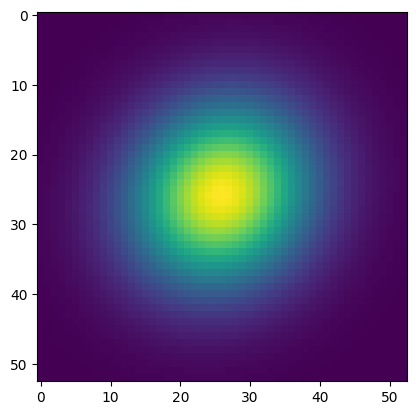

In [58]:
plt.imshow(noiseless)

In [47]:
init_positions['lf'] = true_params['lf'] + 0.25
init_positions['hlr'] = true_params['hlr'] + 1.0
# init_positions['e1'] = true_params['e1'] + 0.2

In [48]:
gkeys = random.split(gkey, (n_gals, 2))
wkeys = gkeys[:, 0]
ikeys = gkeys[:, 1]

In [49]:
# warmup
t1 = time.time()
init_states, tuned_params, adapt_info = _run_warmup(wkeys, init_positions, target_images)
t2 = time.time()
t_warmup = t2 - t1
tuned_params.pop("max_num_doublings")

Array([5], dtype=int64, weak_type=True)

In [50]:
tuned_params

{'inverse_mass_matrix': Array([[2.04217895e-04, 1.18683731e-04, 3.50197428e-04, 4.90927954e-05,
         1.42117585e-02, 1.11677215e-02]], dtype=float64),
 'step_size': Array([0.46169621], dtype=float64, weak_type=True)}

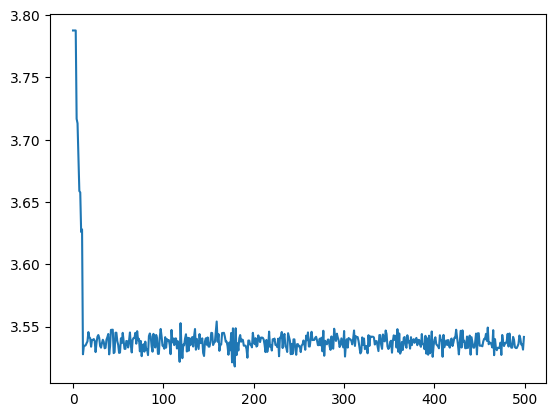

In [51]:
plt.plot(adapt_info.state.position['lf'][0])

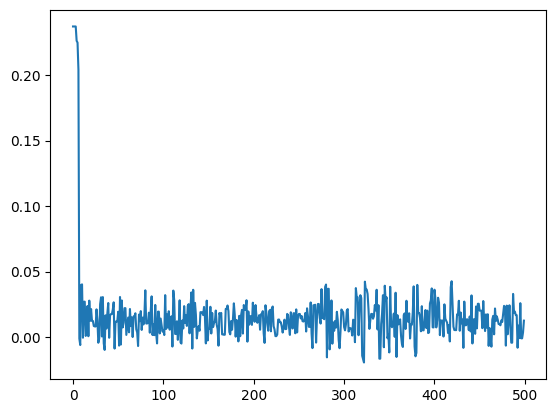

In [52]:
plt.plot(adapt_info.state.position['e1'][0])

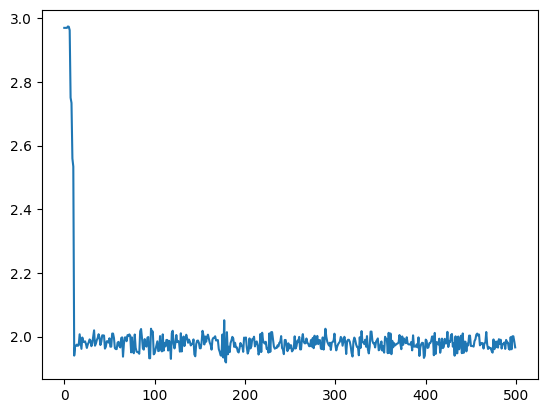

In [53]:
plt.plot(adapt_info.state.position['hlr'][0])

In [16]:
# inference
t1 = time.time()
samples = _run_sampling(ikeys, init_states, tuned_params, target_images)
t2 = time.time()
t_sampling = t2 - t1

In [19]:
results[n_gals] = {}
results[n_gals]["t_warmup"] = t_warmup
results[n_gals]["t_sampling"] = t_sampling
results[n_gals]['samples'] = samples

In [20]:
samples['lf'].shape

(1, 100)

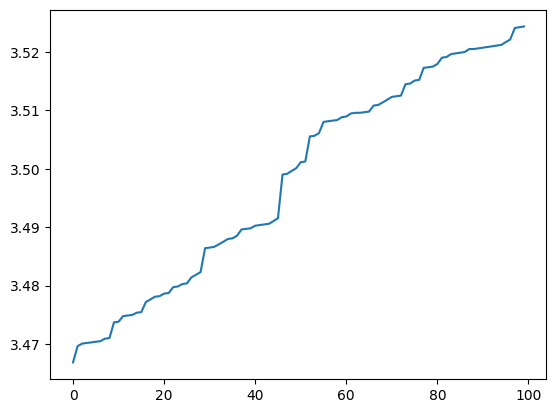

In [23]:
plt.plot(samples['lf'][0])

## Samples from script

In [4]:
results_dict = jnp.load("/pscratch/sd/i/imendoza/data/cache_chains/test_image_sampling_42/chain_results_42.npy", allow_pickle=True).item()
                   
                   
                   

(2, 100, 2)

In [12]:
results_dict.item()[1].keys()

dict_keys(['t_warmup', 't_sampling', 'samples'])

In [20]:
results_dict[5]['samples']['lf'].shape

(5, 4, 100)

In [28]:
results_dict[5]['samples']['hlr'].dtype

dtype('float64')

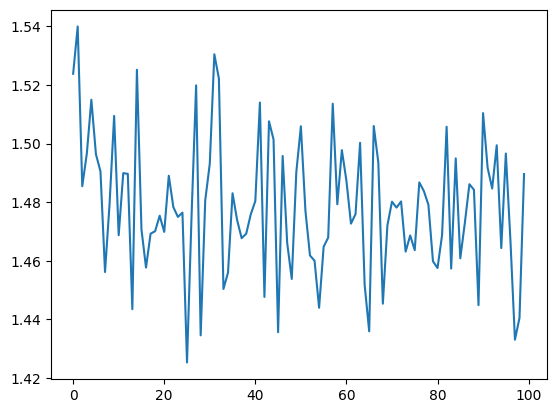

In [27]:
plt.plot(results_dict[5]['samples']['hlr'][0, 2, :])

In [ ]:
results

In [17]:
results_dict[5]['t_sampling']

8.717916250228882

In [18]:
results_dict[5]['t_warmup']

21.794591426849365

## Samples from shear inference intermediate step

In [22]:
results = jnp.load("/pscratch/sd/i/imendoza/data/cache_chains/test_fixed_shear_inference_images_42/e_post_42.npz")

In [23]:
e_post = results['e_post']
e_post.shape

(1000, 100, 2)

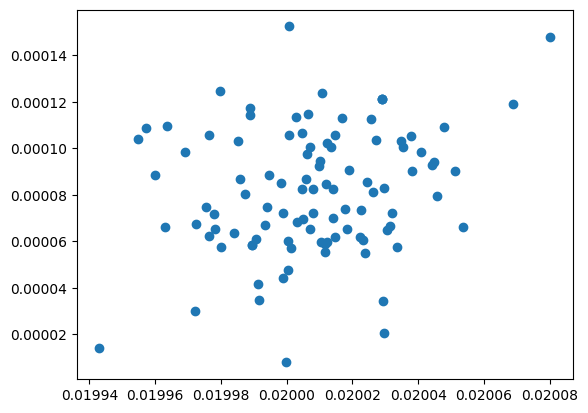

In [24]:
plt.scatter(e_post[0, :, 0], e_post[0, :, 1])

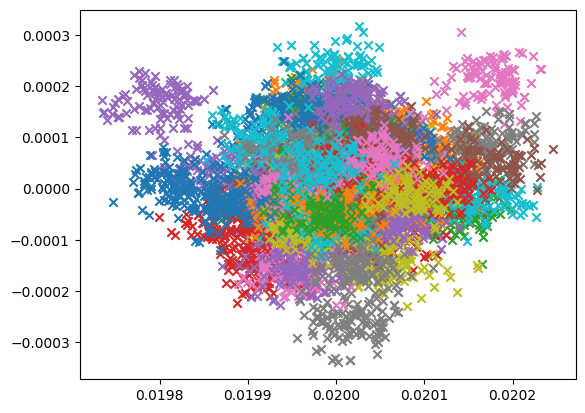

In [25]:
for ii in range(100):
    plt.scatter(e_post[ii, :, 0], e_post[ii, :, 1], marker='x')